## Titanic

In [1]:
import pandas as pd
import numpy as np
import warnings
import itertools

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import LabelEncoder

In [3]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [12, 8]})
warnings.filterwarnings("ignore")

### Custom Functions

In [5]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
def data_viz(df, cols, target = None, plot_type = 'bar'):
    col_length = len(cols)
    
    if(plot_type == 'hist'):
        col_prop = round(col_length/2)
        fig, ax = plt.subplots(col_prop, 2, figsize=(20, 6 * col_prop))
    else:
        col_prop = round(col_length/2)
        fig, ax = plt.subplots(col_prop, 2, figsize=(20, 7 * col_prop))
    
    if(plot_type=='bar_target'):
        for variable, subplot in zip(cols, ax.flatten()):
            ct = pd.crosstab(df[variable], df[target])
            ct.plot.bar(stacked=True, ax=subplot)
            for label in subplot.get_xticklabels():
                label.set_rotation(15)
    elif(plot_type == 'bar'):
        for variable, subplot in zip(cols, ax.flatten()):
            sns.countplot(df[variable], ax=subplot)
            for label in subplot.get_xticklabels():
                label.set_rotation(30)
    elif(plot_type == 'box'):       
        for variable, subplot in zip(cols, ax.flatten()):
            sorted_vals = df.groupby([variable])[target].mean().sort_values()
            sns.boxplot(x=variable, y=target, data=df, ax=subplot, order=list(sorted_vals.index))
            for label in subplot.get_xticklabels():
                label.set_rotation(30)
    elif(plot_type == 'hist'):
        for variable, subplot in zip(cols, ax.flatten()):
            df[variable].fillna(df[variable].mean(), inplace=True)
            sns.distplot(df[variable], ax=subplot)
            for label in subplot.get_xticklabels():
                label.set_rotation(15)

#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Loading Train and Test datasets

In [6]:
train = pd.read_csv('./data/titanic/train.csv')

In [7]:
test = pd.read_csv(f'./data/titanic/test.csv')

In [8]:
train.shape, test.shape

((891, 12), (418, 11))

In [9]:
display_all(train.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- Survived: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
- Pclass: passenger class.
- Name, Sex, Age: self-explanatory
- SibSp: how many siblings & spouses of the passenger aboard the Titanic.
- Parch: how many children & parents of the passenger aboard the Titanic.
- Ticket: ticket id
- Fare: price paid (in pounds)
- Cabin: passenger's cabin number
- Embarked: where the passenger embarked the Titanic

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [11]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Exploratory Data Analysis

In [12]:
numeric_cols = train.select_dtypes(exclude=['object']).columns.tolist()
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()

In [13]:
len(numeric_cols), len(categorical_cols)

(7, 5)

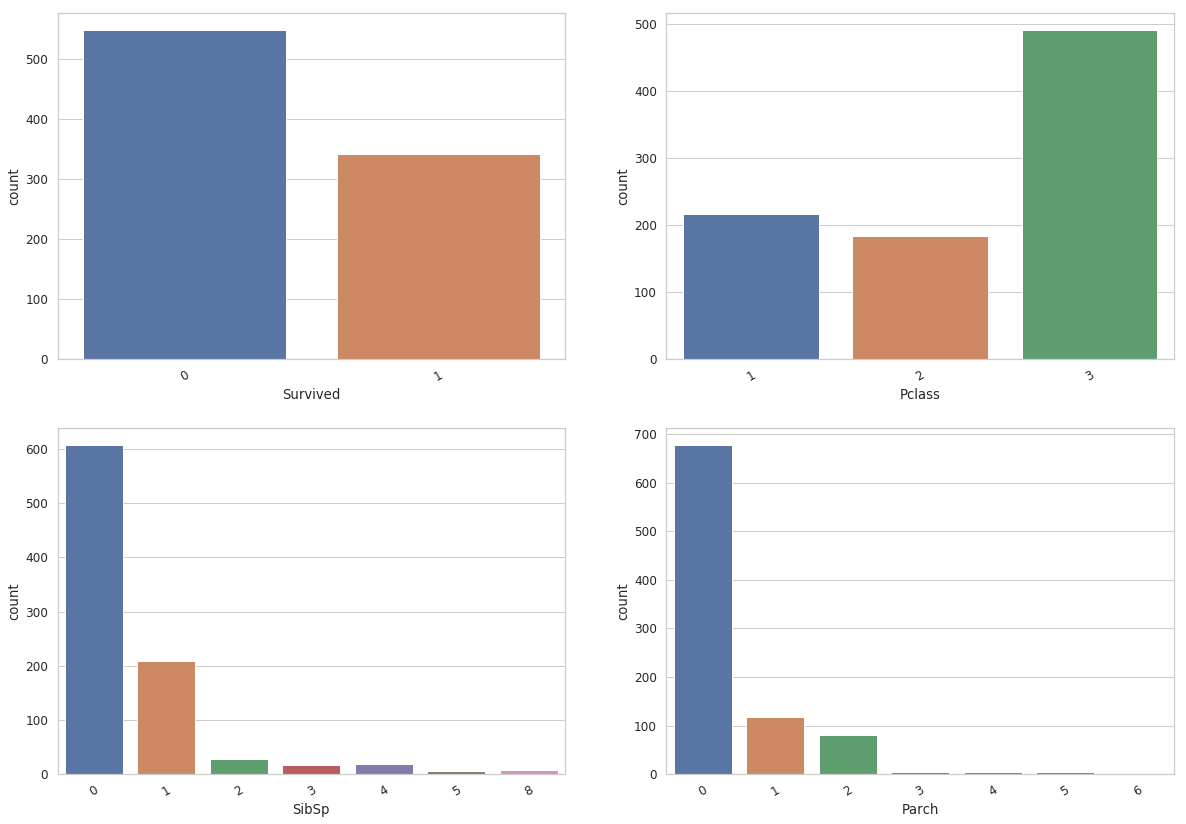

In [14]:
data_viz(train, cols = ['Survived', 'Pclass', 'SibSp', 'Parch'], plot_type = 'bar')

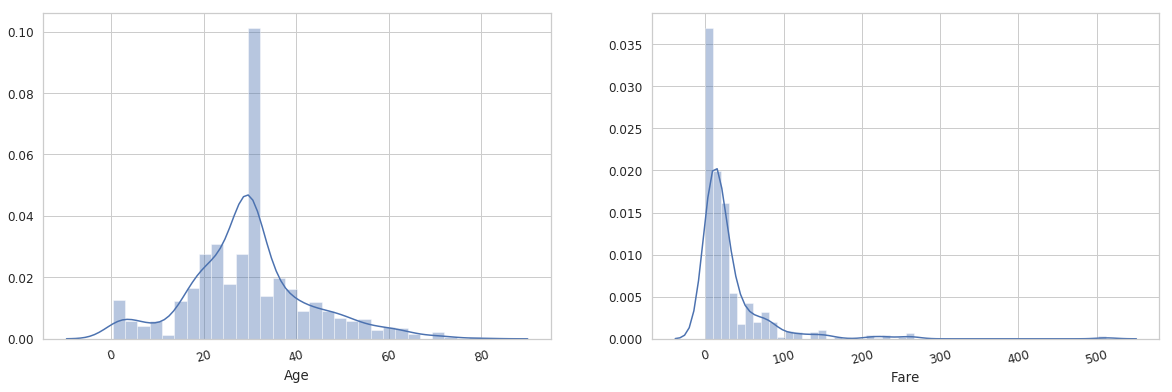

In [15]:
data_viz(train, cols = ['Age', 'Fare'], plot_type = 'hist')

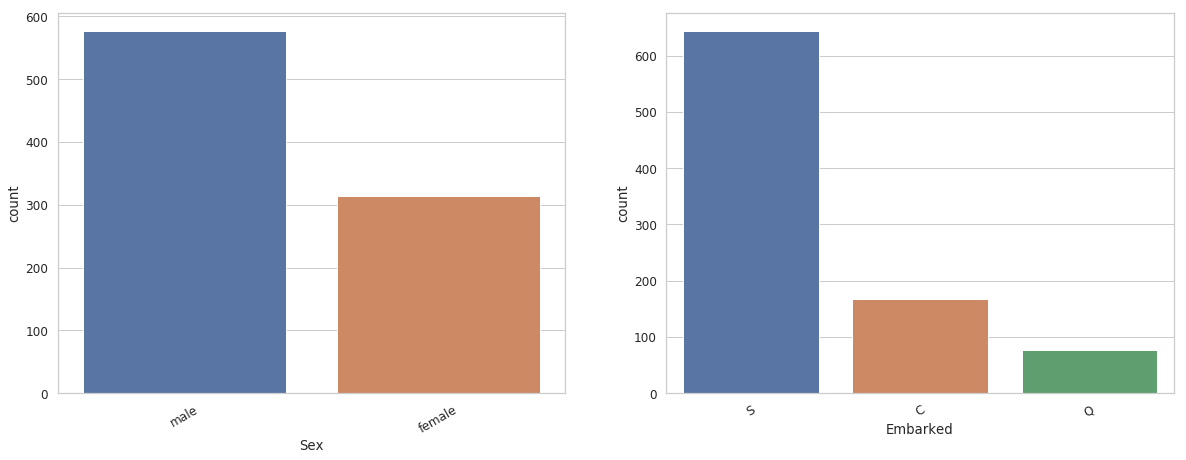

In [16]:
data_viz(train, cols = ['Sex', 'Embarked'], plot_type = 'bar')

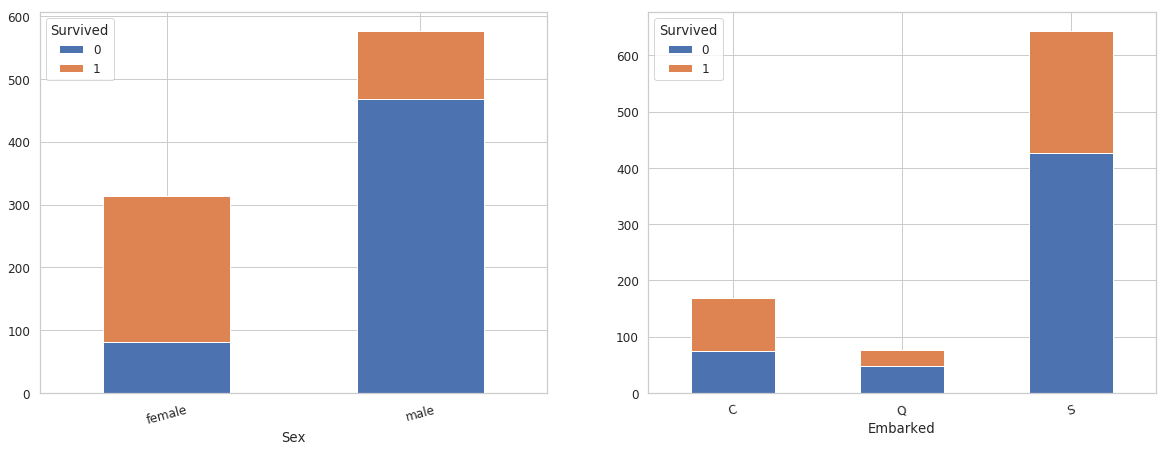

In [17]:
data_viz(train, cols = ['Sex', 'Embarked'], target='Survived', plot_type = 'bar_target')

In [18]:
for col in ['Sex', 'Embarked', 'Pclass', 'Parch', 'SibSp']:
    print(train.groupby(col)['Survived'].agg('mean').reset_index().sort_values('Survived', ascending=False))
    print('\n')

      Sex  Survived
0  female  0.742038
1    male  0.188908


  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957


   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000


   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000




array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f07ceed9710>,
      dtype=object)

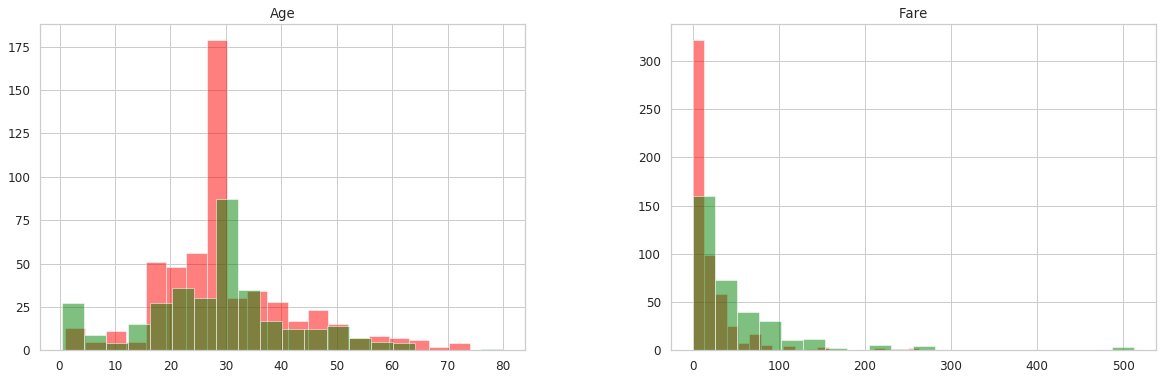

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
train[train['Survived'] == 0][['Age', 'Fare']].hist(bins=20, color="red", alpha=0.5, ax=ax)
train[train['Survived'] == 1][['Age', 'Fare']].hist(bins=20, color="green", alpha=0.5, ax=ax)

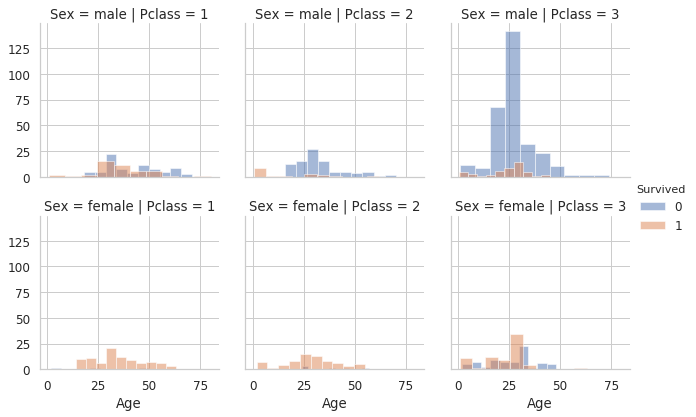

In [20]:
#histogram comparison of sex, class, and age by survival
h = sns.FacetGrid(train, row = 'Sex', col = 'Pclass', hue = 'Survived')
h.map(plt.hist, 'Age', alpha = .5)
h.add_legend()

In [21]:
# correlation_heatmap(train)

### Feature Engineering

In [22]:
test['Survived'] = 0

In [23]:
train['is_train'] = 1
test['is_train'] = 0

In [24]:
train.shape, test.shape

((891, 13), (418, 13))

##### Combine train and test into one dataframe

In [25]:
full_df = train.append(test)

In [26]:
full_df.shape

(1309, 13)

#### Adding some features

In [27]:
full_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,is_train
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599,1
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803,1
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450,1


In [28]:
full_df['FamilySize'] = 1 + full_df['SibSp'] + full_df['Parch']

In [29]:
full_df['Is_Alone'] = np.where(full_df['FamilySize'] == 1, 1, 0)

In [30]:
full_df['Title'] = full_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
full_df['Title'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Major         2
Ms            2
Mlle          2
Sir           1
Capt          1
Countess      1
Dona          1
Jonkheer      1
Lady          1
Don           1
Mme           1
Name: Title, dtype: int64

In [31]:
full_df['Title'] = full_df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
full_df['Title'] = full_df['Title'].replace('Mlle', 'Miss')
full_df['Title'] = full_df['Title'].replace('Ms', 'Miss')
full_df['Title'] = full_df['Title'].replace('Mme', 'Mrs')

### Check for missing values

In [32]:
missing_stats = full_df.isnull().mean()
print(round(100 * missing_stats[missing_stats != 0],2))
print('\n')

Age          6.57
Cabin       77.46
Embarked     0.15
Fare         0.08
dtype: float64




### Fix missing values

In [33]:
full_df['Embarked'] = full_df['Embarked'].fillna(full_df['Embarked'].mode()[0])

In [34]:
full_df['Cabin'] = full_df['Cabin'].fillna('U')
full_df['Cabin'] = full_df['Cabin'].map(lambda c: c[0])

In [35]:
full_df.fillna(full_df.mean(), inplace=True)

### Encoding Categorical Data

In [36]:
full_df.drop(columns = ['Name', 'Ticket'], axis=1, inplace=True)

In [37]:
full_df = pd.get_dummies(full_df)

### Transforming data back to train and test

In [38]:
train = full_df[full_df['is_train'] == 1]
test = full_df[full_df['is_train'] == 0]

In [39]:
train.shape, test.shape

((891, 29), (418, 29))

In [40]:
display_all(train.head())

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,is_train,FamilySize,Is_Alone,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,22.0,7.2500,0,1,3,1,0,1,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0
1,38.0,71.2833,0,2,1,1,1,1,2,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
2,26.0,7.9250,0,3,3,0,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0
3,35.0,53.1000,0,4,1,1,1,1,2,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0
4,35.0,8.0500,0,5,3,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0


### Final preprocessing steps

In [41]:
skip_cols = ['PassengerId', 'Survived', 'is_train']

In [42]:
X = train.drop(skip_cols, axis=1)
y = train['Survived'].values

### Splitting Data into Train, Validation sets

In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0)

### Decision Tree Model

In [44]:
DT_model = DecisionTreeClassifier( min_samples_leaf=3
                                 , max_features=0.8
                                 , random_state = 0
                                 , max_depth=6
                                )

In [45]:
DT_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=0.8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [46]:
DT_Predictions = DT_model.predict(X_valid)

In [47]:
DT_Probabilities = DT_model.predict_proba(X_valid)[:,1]

In [48]:
accuracy_score(DT_Predictions, y_valid)

0.8116591928251121

### Random Forest Model

In [49]:
RF_model = RandomForestClassifier( n_estimators=1000
                                 , min_samples_leaf=3
                                 , max_features=0.8
                                 , n_jobs=-1
                                 , random_state = 0
                                )

In [50]:
RF_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [51]:
RF_Predictions = RF_model.predict(X_valid)

In [52]:
RF_Probabilities = RF_model.predict_proba(X_valid)[:,1]

In [53]:
accuracy_score(RF_Predictions, y_valid)

0.8609865470852018

Confusion matrix, without normalization
[[130   9]
 [ 22  62]]
Normalized confusion matrix
[[0.94 0.06]
 [0.26 0.74]]


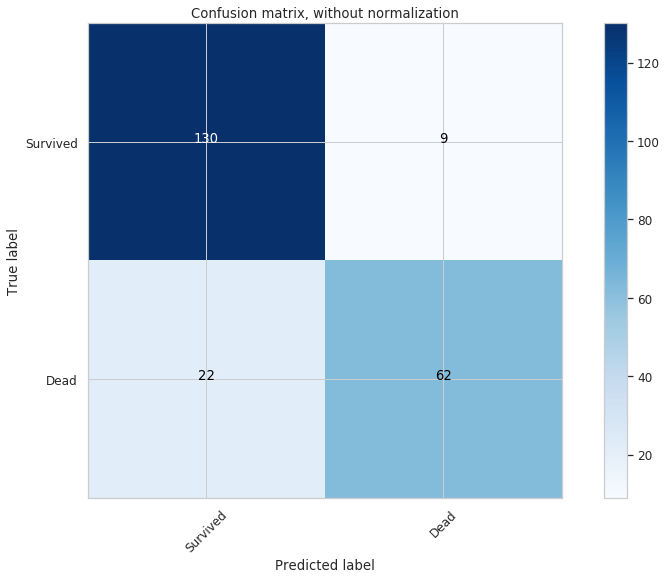

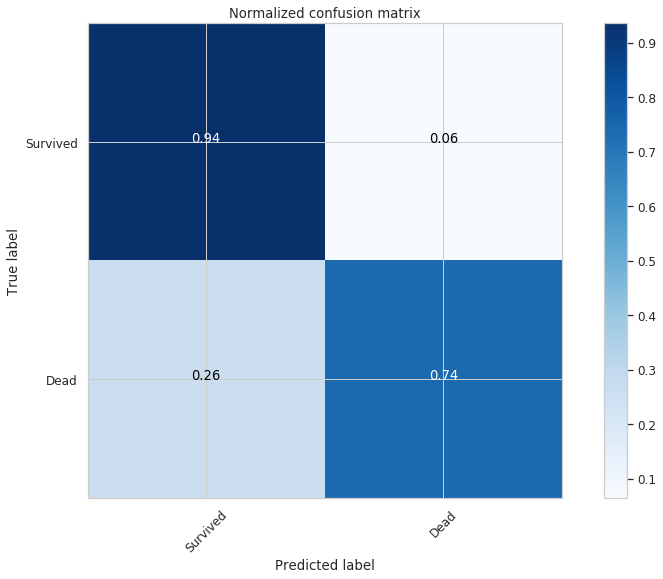

In [67]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_valid, RF_Predictions)
np.set_printoptions(precision=2)

class_names = ['Survived', 'Dead']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')

In [55]:
precision_score(RF_Predictions, y_valid)

0.7380952380952381

In [56]:
recall_score(RF_Predictions, y_valid)

0.8732394366197183

In [57]:
f1_score(RF_Predictions, y_valid)

0.8

In [58]:
precisions, recalls, thresholds = precision_recall_curve(y_valid, RF_Probabilities)

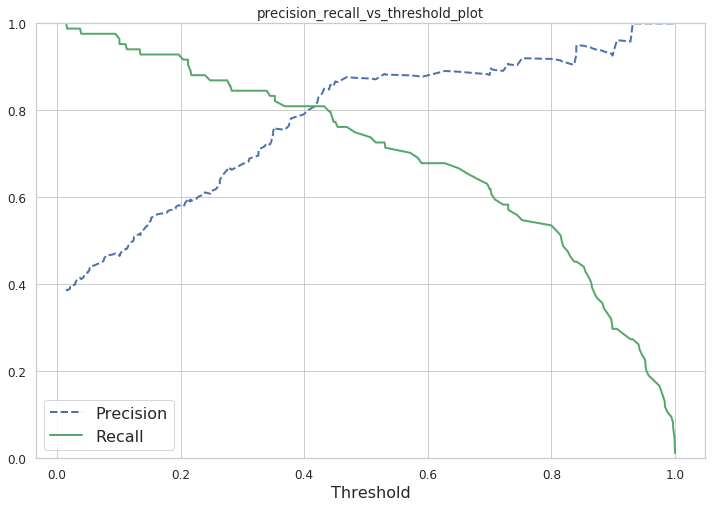

In [59]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="best", fontsize=16)
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.title("precision_recall_vs_threshold_plot")
plt.show()

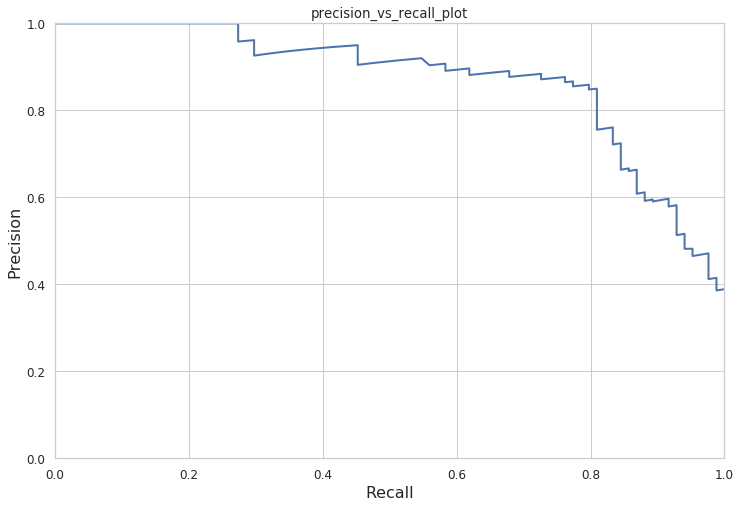

In [60]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plot_precision_vs_recall(precisions, recalls)
plt.title("precision_vs_recall_plot")
plt.show()

In [61]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_valid, RF_Probabilities)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_valid, DT_Probabilities)

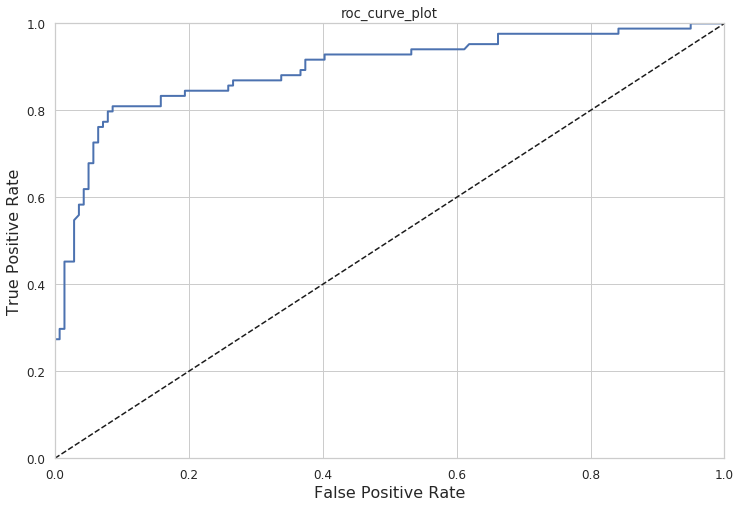

In [62]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plot_roc_curve(fpr_rf, tpr_rf)
plt.title("roc_curve_plot")
plt.show()

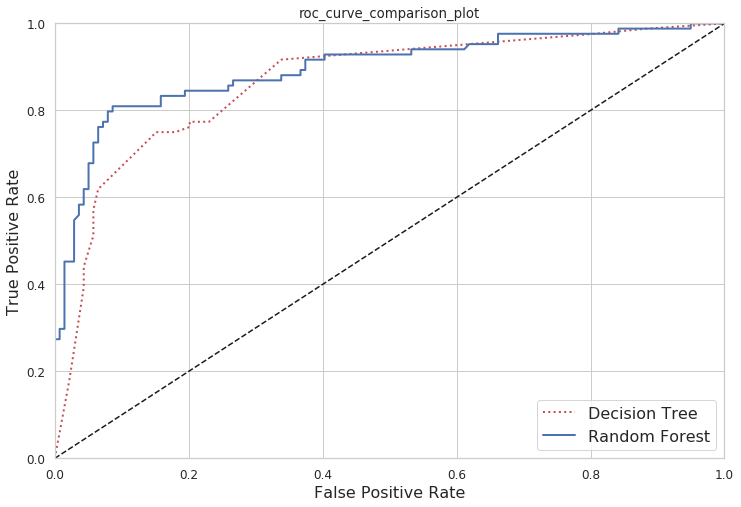

In [63]:
plt.plot(fpr_dt, tpr_dt, "r:", linewidth=2, label="Decision Tree")
plot_roc_curve(fpr_rf, tpr_rf, "Random Forest")
plt.legend(loc="best", fontsize=16)
plt.title("roc_curve_comparison_plot")
plt.show()

In [64]:
roc_auc_score(y_valid, RF_Probabilities)

0.895083932853717

In [65]:
roc_auc_score(y_valid, DT_Probabilities)

0.8643799246317233

In [66]:
print(classification_report(RF_Predictions, y_valid, target_names=['Survived', 'Dead']))

              precision    recall  f1-score   support

    Survived       0.94      0.86      0.89       152
        Dead       0.74      0.87      0.80        71

    accuracy                           0.86       223
   macro avg       0.84      0.86      0.85       223
weighted avg       0.87      0.86      0.86       223

